In [1]:
import pandas as pd
import numpy as np
import itertools
from scipy import stats as st 
st.keepsdims = True
#suppress depreciation warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
from joblib import Parallel, delayed
import tqdm


In [2]:
""" 
X_train = pd.read_csv("MNIST_train_small.csv", header = None)
y_train = X_train.iloc[:,0]
X_train = X_train.drop(X_train.columns[0], axis=1)

X_test = pd.read_csv("MNIST_test_small.csv", header = None)
y_test = X_test.iloc[:,0]
X_test = X_test.drop(X_test.columns[0], axis=1)
 """

' \nX_train = pd.read_csv("MNIST_train_small.csv", header = None)\ny_train = X_train.iloc[:,0]\nX_train = X_train.drop(X_train.columns[0], axis=1)\n\nX_test = pd.read_csv("MNIST_test_small.csv", header = None)\ny_test = X_test.iloc[:,0]\nX_test = X_test.drop(X_test.columns[0], axis=1)\n '

In [3]:
X_full = pd.read_csv("MNIST_train.csv", header = None)
#convert columns to np.unit8
X_full = X_full.astype(np.uint8)
y_full = X_full.iloc[:,0]
X_full = X_full.drop(X_full.columns[0], axis=1)
#resized to 5x5
from PIL import Image
X_pixels = X_full.values
X_pixels = X_pixels.reshape(-1, 28, 28)
# Set new size
new_size = (5, 5)

# Resize training set
X_resized = np.zeros((len(X_full),) + new_size)
for i in range(X_pixels.shape[0]):
    img = Image.fromarray(X_pixels[i])
    img_resized = img.resize(new_size)
    X_resized[i] = np.array(img_resized)


X_resized_pixels = X_resized.reshape(-1, new_size[0]*new_size[1])

# Add the label column back into the pandas dataframe
X_resized_df = pd.DataFrame(data=X_resized_pixels, columns=['pixel'+str(i) for i in range(new_size[0]*new_size[1])])
X_resized= X_resized_df.astype(np.uint8)





In [4]:
#remove X_full and y_full from memory
del X_full
del X_pixels
del img_resized
del X_resized

In [27]:
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))


In [28]:
def predict_for_multiple_k(x, dist_function, X, y, k_values, LOOCV=False):
    dist_to_all = np.apply_along_axis(lambda row: dist_function(x, row), 1, X)
   
    dist_to_all = np.column_stack((dist_to_all, y))
    
    dist_to_all = dist_to_all[np.argsort(dist_to_all[:, 0])]
   

    predictions = []
    for k in k_values:
        k_original = k
      
        neighbor_indeces = dist_to_all[:k, -1].astype(np.uint8)
        neighbor_classifications = y.take(neighbor_indeces)
        closest = st.mode(neighbor_classifications)[0]

        while len(closest) > 1:
            k += 1
            neighbor_indeces = np.append(neighbor_indeces, int(dist_to_all[k, -1]))
            neighbor_classifications = y.take(neighbor_indeces)
            closest = st.mode(neighbor_classifications)[0]

        prediction = closest[0]
        predictions.append((k_original, prediction))
    return predictions


In [29]:
def get_accuracies(X_test, y_test, X_train, y_train, distance_function=euclidean_distance, k=[10], updates=250):
    X_train_num = X_train.to_numpy()
    correct_counters = {x: {"correct": 0, "false": 0} for x in k}
    for index, row in X_test.iterrows():
        preds = predict_for_multiple_k(row.to_numpy(), distance_function, X_train_num, y_train, k)
        correct = y_test.iloc[index]
        for k_val, pred in preds:
            if correct == pred:
                correct_counters[k_val]["correct"] += 1
            else:
                correct_counters[k_val]["false"] += 1
        if index % updates == 0:
            print(f'iter: {index} {correct_counters}')
    return correct_counters


In [30]:
#accuracies_test = get_accuracies(X_test, y_test, X_train, y_train, euclidean_distance, list(range(1,21)), 1000)

In [31]:
#find the key with higher accuracy
#max_key = max(accuracies_test, key=lambda x: accuracies_test[x]["correct"]/(accuracies_test[x]["correct"]+accuracies_test[x]["false"]))

In [32]:
def LOOCV(X_train, y_train, distance_function = euclidean_distance, k = [10], updates = 250):
    correct_counters = dict([(x, {"correct": 0, "false": 0}) for x in k])
    
    #wrap the for loop in a tqdm to show progress
    with tqdm.tqdm(total=len(X_train)) as pbar:
        #parallelize the for loop
        
        
        for index, row in X_train.iterrows():
        
            loocv_X_train = X_train.drop(index).values
            loocv_y_train = y_train.drop(index).values
            preds = predict_for_multiple_k(row.values, distance_function, loocv_X_train, loocv_y_train, k, LOOCV=True)
            #print("done")
            correct = y_train.iloc[index]
            
            for k_val, pred in preds:
                if correct == pred:
                    correct_counters[k_val]["correct"] += 1
                else:
                    correct_counters[k_val]["false"] += 1
            
            #print("finished checking")
            if (index + 1) % updates == 0:
                print(f'Processed {index + 1} rows')
            pbar.update(1)

            
        
    return correct_counters


## Paralelize

In [34]:

def process_row(index, row, X_train, y_train, distance_function, k_values):
    """ loocv_X_train = X_train.drop(index).values
    loocv_y_train = y_train.drop(index).values """
    preds = predict_for_multiple_k(row.values, distance_function, X_train, y_train, k_values, LOOCV=True)

    correct = y_train.iloc[index]

    local_correct_counters = dict([(x, {"correct": 0, "false": 0}) for x in k_values])

    for k_val, pred in preds:
        if correct == pred:
            local_correct_counters[k_val]["correct"] += 1
        else:
            local_correct_counters[k_val]["false"] += 1

    return local_correct_counters


In [35]:

def LOOCV(X_train, y_train, distance_function = euclidean_distance, k = [10], updates = 250, n_jobs = -1):
    correct_counters = dict([(x, {"correct": 0, "false": 0}) for x in k])

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(
            index, row, X_train, y_train, distance_function, k
        ) for index, row in tqdm.tqdm(X_train.iterrows(), total=len(X_train))
    )

    for local_correct_counters in results:
        for k_val in k:
            correct_counters[k_val]["correct"] += local_correct_counters[k_val]["correct"]
            correct_counters[k_val]["false"] += local_correct_counters[k_val]["false"]

    return correct_counters


In [14]:
accuracies_LOOCV= LOOCV(X_resized_df, y_full, euclidean_distance, list(range(1,21)), 1000,12)

100%|██████████| 60000/60000 [2:38:50<00:00,  6.30it/s]  


In [30]:
#parquet accuracies_LOOCV
with open('accuracies_LOOCV.pickle', 'wb') as handle:
    pickle.dump(accuracies_LOOCV, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [22]:
#read in the accuracies from the pickle file
 
with open('accuracies_LOOCV.pickle', 'rb') as handle:
    accuracies_LOOCV = pickle.load(handle)

In [23]:
max_key= max(accuracies_LOOCV, key=lambda x: accuracies_LOOCV[x]["correct"]/(accuracies_LOOCV[x]["correct"]+accuracies_LOOCV[x]["false"]))

In [24]:
X_test= pd.read_csv("MNIST_test.csv")
y_test= X_test["7"]
X_test= X_test.drop("7",axis=1)


In [36]:
test_accuracy= LOOCV(X_test, y_test, euclidean_distance, [max_key], 1000, 12)

100%|██████████| 9999/9999 [09:53<00:00, 16.84it/s]


In [5]:
def calc_emp_risk(accuracies):
    # Get empirical risk for each k
    empirical_risks = {}
    for k, loss in accuracies.items():
        # Get size of first item (should all be equal)
        n = sum(loss.values())

        # Calc risk
        risk = (1/n)*loss['false']
        empirical_risks[k] = risk
        
    # Get best empirical risk for k
    min_val = min(empirical_risks.values())
    optimal_k = [k for k in empirical_risks if empirical_risks[k] == min_val][0] # argmin for dict
    
    return empirical_risks, optimal_k

In [42]:
with open('test_acc.pickle', 'wb') as handle:
    pickle.dump(test_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('accuracies_LOOCV.pickle', 'rb') as handle:
    locv_acc = pickle.load(handle)

In [ ]:
with open('test_acc.pickle', 'rb') as handle:
    test_acc = pickle.load(handle)

In [6]:
locv_risk,k= calc_emp_risk(locv_acc)

In [ ]:
test_acc,_= calc_emp_risk(test_acc)

Text(0.5, 1.0, 'LOOCV risk for k')

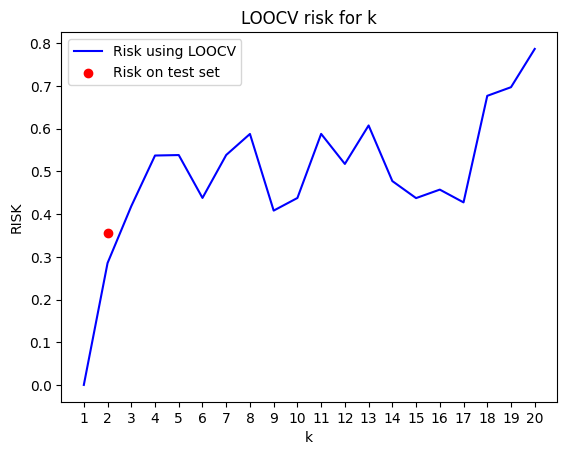

In [30]:
x_risk= list(locv_risk.keys())
y_risk= list(locv_risk.values())
plt.xticks(x_risk)

plt.plot(x_risk, y_risk, color='blue', label="Risk using LOOCV")
#set a point at x=2 y=0.267
plt.scatter(k,test_acc, color='red', label="Risk on test set")
plt.legend()
plt.xlabel('k')
plt.ylabel('RISK')
plt.title('LOOCV risk for k')